<a href="https://colab.research.google.com/github/PawelJakubczyk/ham_or_spam_classifier/blob/main/spam_or_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup: Install Required Libraries
<a id="section1"></a>

In [1]:
%pip install numpy
%pip install pandas
%pip install language_tool_python
%pip install matplotlib
%pip install seaborn
# %pip install scikit-learn
# %pip install spycy
# %pip install nlpaug
# %pip install googletrans

%pip install concurrent
%pip install textaugment

  Preparing metadata (setup.py) ... done
  Created wheel for spycy: filename=spycy-0.2-py3-none-any.whl size=2264 sha256=af56cef505b2ac66f3a6091a03bc3c4bd329207eda875bca895f651841e0fde1
  Stored in directory: /root/.cache/pip/wheels/3c/f9/75/dccd2a38a678b2115f1112d80e8d4d21df2d1cb5854d22bc14
Successfully built spycy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement concurrent (from versions: none)
ERROR: No matching distribution found for concurrent
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━

# Data Sorce

## https://www.kaggle.com/datasets/mfaisalqureshi/spam-email

# Import Libraries
<a id="section2"></a>

In [72]:
# Read manage data
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

# Data Preprocesing
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from typing import Set
from re import sub
import string
import nltk
import spacy

# data augmentation
from textaugment import Wordnet

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data Analiss
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Define Functions

### Data cleaning

1. **normalize_text(input_text: str) -> str**:
   This function normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces.

2. **remove_punctuation(input_string: str) -> str**:
   This function removes punctuation marks from the input string.

3. **replace_tabs_enters_and_spaces(input_string:str) -> str**:
   This function takes an input string and replaces tabs with a single space and multiple consecutive spaces with a single space.

4. **remove_stopwords(input_string: str, stop_words: Set[str]) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

5. **remove_html_tags(input_text: str) -> str**:
   This function removes HTML tags from the input text.

6. **remove_stopwords(input_string: str, stop_words: Set[str]) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

7. **lemmatize(text: str) -> str**:
   This function lemmatizes the input text. Lemmatization is similar to stemming but considers the context of the word to determine its base or dictionary form.

8. **stemming(text: str) -> str**:
   This function performs stemming on the input text. Stemming reduces words to their root or base form, often by removing suffixes.

9. **remove_pos_tags(text: str) -> str**:
   This function removes all words from the input text except for nouns (NN). It relies on part-of-speech tagging to identify and retain only nouns in the text.

10. **clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame**:
    Cleans the input DataFrame by removing rows with missing value or empty strings.

In [271]:
# Prior to running the functions, required resources need to be downloaded
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
STOP_WORDS = nlp.Defaults.stop_words
stemmer = PorterStemmer()

def normalize_text(input_text: str) -> str:
    """Normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces."""
    # Convert to lowercase
    normalized_text = input_text.lower()

    # Remove leading and trailing whitespaces
    normalized_text = normalized_text.strip()

    return normalized_text

def remove_punctuation(input_string: str) -> str:
    """Removes punctuation from the input string"""
    return input_string.translate(str.maketrans('', '', string.punctuation))

def replace_tabs_enters_and_spaces(input_string:str) -> str:
    """Replaces tabs with a single space and multiple spaces with a single space in the input string"""
    replaced_tabs = sub(r'\t', ' ', input_string)
    replace_enters = sub(r'\n', ' ', replaced_tabs)
    replaced_spaces = sub(r'\s+', ' ', replace_enters)
    return replaced_spaces

def remove_html_tags(input_text: str) -> str:
    """Removes HTML tags from the input text."""
    clean_text = sub(r'<.*?>', '', input_text)
    return clean_text

def remove_stopwords(input_string: str) -> str:
    """Removes stopwords from the input string"""
    words = input_string.split()
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    return ' '.join(filtered_words)

def lemmatize(input_string: str)-> str:
    """Lemmatizes the input text"""
    doc = nlp(input_string)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    return ' '.join(sent)

def stemming(input_string: str)-> str:
    """Performs stemming on the input text"""
    tokens = word_tokenize(input_string)
    stem_words = [stemmer.stem(word) for word in tokens]
    return ' '.join(stem_words)

def remove_pos_tags(input_string: str)-> str:
    """Removes all words except nouns (NN) from the input text"""
    doc = nlp(input_string)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

def clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame:
    """Cleans the input DataFrame by removing rows with incorrect or invalid values."""

    cleaned_df = df.copy()  # Make a copy to avoid modifying the original DataFrame

    for column in columns_to_check:
        cleaned_df = cleaned_df[cleaned_df[column].notna()]  # Remove rows with missing values
        cleaned_df = cleaned_df[cleaned_df[column] != ""]  # Remove rows with empty strings

    return cleaned_df

# Only the first two preprocessing functions are used because they have the highest percentage of coverage in the model.
# The remaining functions are left in the notebook to demonstrate various preprocessing options.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Merge functions for preprocesing

In [272]:
def preprocess_text(input_string: str) -> str:
    """Preprocesses the input text by applying a series of text processing steps."""
    # Step 1: normalize_text
    processed_text = normalize_text(input_string)
    # Step 2: Remove punctuation
    processed_text = remove_punctuation(processed_text)
    # Step 3: Replace tabs, enters, and multiple spaces with single spaces
    processed_text = replace_tabs_enters_and_spaces(processed_text)

    return processed_text

### Data translate

In [273]:
def translate_to_english(input_string:str) -> str:
    """Translates the input string to English using the Google Translate API."""
    translator = Translator()
    try:
        return translator.translate(input_string, dest='en').text
    except Exception:
        print(f"Translation Error: {Exception}")
    return input_string

### Data augmentation

1. **augment_data(data, topic_col, text_col) -> DataFrame**: Data augmentation is a technique used to artificially increase the size of a dataset by creating modified versions of existing data samples. The `augment_data` function implements this technique by generating additional samples for underrepresented topics in the input data.

In [274]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def augment_data(data: pd.DataFrame, topic_col: str, text_col: str) -> pd.DataFrame:
    """Augments the input data by generating additional samples for underrepresented topics."""

    topic_counts = data[topic_col].value_counts()  # get the topic counts
    max_count = topic_counts.max()  # max items for main topic

    augmented_data = []
    wordnet_aug = Wordnet(v=True)  # use Wordnet for synonyms

    # Loop through each topic to create additional data
    for topic, count in topic_counts.items():
        # Get data corresponding to the current topic
        topic_data = data[data[topic_col] == topic]

        # Calculate the number of additional samples needed for this topic
        samples_needed = max_count - count

        # Perform augmentation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            # Augment a randomly selected text from the current topic
            augmented_sentence = wordnet_aug.augment(topic_data[text_col].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)

        # Create a new DataFrame with merged newly created samples and topics
        augmented_df = pd.DataFrame({topic_col: [topic] * len(augmented_sentences),
                                      text_col: augmented_sentences})

        # Add the augmented samples to the list
        augmented_data.append(augmented_df)

    # Merge the newly created DataFrame with samples and the original data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

    # Return the augmented data
    return augmented_data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Analize

In [275]:
def analyze_word_frequency_in_df_column(df: pd.DataFrame, column_name: str, top_num: int) -> dict:
    all_text = ' '.join(df[column_name].astype(str).tolist())
    words = word_tokenize(all_text)
    fdist = FreqDist(words)
    most_common_words = dict(fdist.most_common(top_num))

    return most_common_words

def check_missing_values(df: pd.DataFrame, columns: list)-> None:
    """Check missing values in the DataFrame for the specified columns."""

    missing_values = df[columns].replace("", pd.NA).isnull().sum()
    print(missing_values)

### Text tokenization

In [276]:
def tokenize_text(input_string):
    # Tokenize the text into words
    tokens = word_tokenize(input_string)

    return tokens

# Read the spam data from a CSV file

In [277]:
dtype_dict = {'Message': str, 'Category': str}
spam_df=pd.read_csv('/content/spam.csv', dtype=dtype_dict)

# Data Analisis

In [278]:
spam_df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [279]:
print(spam_df.shape)

(5572, 2)


In [280]:
check_missing_values(spam_df, ["Category", "Message"])

Category    0
Message     0
dtype: int64


In [281]:
result = analyze_word_frequency_in_df_column(spam_df, 'Message', 20)
print(result)

{'.': 4894, 'to': 2156, 'I': 1975, ',': 1938, 'you': 1893, '?': 1550, '!': 1398, 'a': 1339, 'the': 1208, '...': 1146, 'i': 954, '&': 919, 'and': 866, 'in': 830, 'is': 821, 'u': 786, ';': 768, 'me': 752, ':': 722, '..': 697}


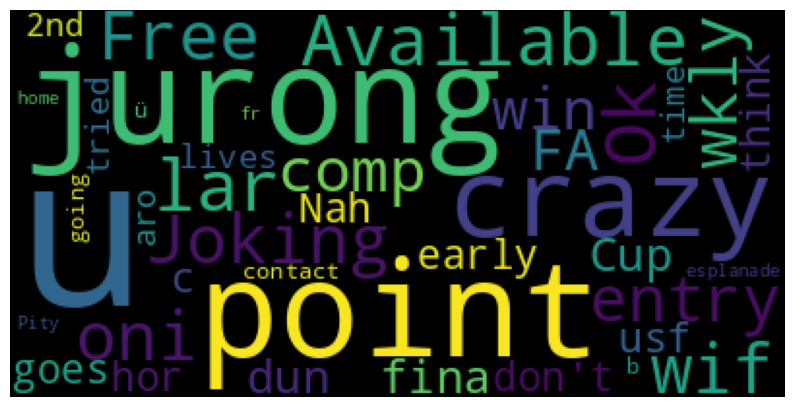

In [282]:
wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(spam_df['Message']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Data prefactoring

### Preproces Words

In [283]:
with ProcessPoolExecutor() as executor:
    spam_df['Message'] = list(executor.map(preprocess_text, spam_df['Message']))

In [284]:
spam_df.head(10)

,Category,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I dont think he goes to usf he lives aroun...
5,spam,FreeMsg Hey there darling its been 3 weeks now...
6,ham,Even my brother is not like to speak with me T...
7,ham,As per your request Melle Melle Oru Minnaminun...
8,spam,WINNER As a valued network customer you have b...
9,spam,Had your mobile 11 months or more U R entitled...


In [285]:
result = analyze_word_frequency_in_df_column(spam_df, 'Message', 20)
print(result)

{'to': 2156, 'you': 1814, 'I': 1498, 'a': 1339, 'the': 1206, 'and': 860, 'in': 827, 'is': 811, 'u': 784, 'i': 752, 'me': 745, 'for': 656, 'my': 631, 'of': 598, 'your': 561, 'it': 546, 'on': 503, '2': 482, 'have': 477, 'that': 466}


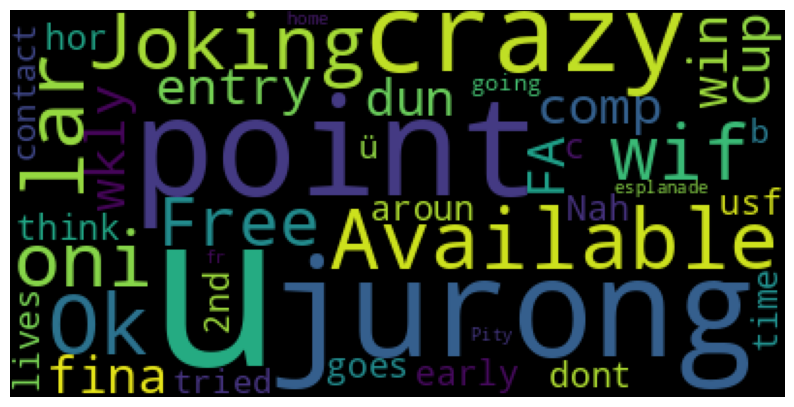

In [286]:
wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(spam_df['Message']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Augument Data

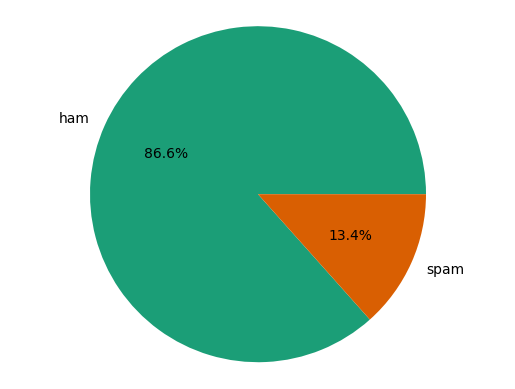

In [287]:
spam_df.groupby('Category').size().plot(kind='pie', colors=sns.color_palette('Dark2'), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [288]:
spam_df = augment_data(spam_df, "Category" ,'Message')

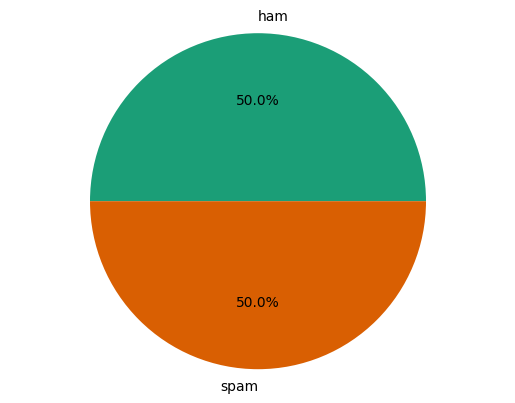

In [289]:
spam_df.groupby('Category').size().plot(kind='pie', colors=sns.color_palette('Dark2'), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

# Model Training

In [290]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spam_df.Message, spam_df.Category, test_size=0.25)

In [291]:
# Create a pipeline for the model
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [292]:
# Fit the model on the training data
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [293]:
# Predict the categories for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Percentage coverage: {accuracy * 100}%")

Percentage coverage: 98.21798590965602%
